<a href="https://colab.research.google.com/github/Ashishgy/MapReduce_Flight/blob/main/Database_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating the Virtual Environment for our Project

In [ ]:
pip install virtualenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 27.5 MB/s eta 0:00:00


Installing Required Libraries

In [ ]:
pip install pandas networkx matplotlib

Uploading airports.dat and routes.dat

In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving airports.dat.txt to airports.dat (1).txt
Saving routes.dat.txt to routes.dat (1).txt


Checking the Data file in both the files that we have uploaded

In [ ]:
import pandas as pd

# Assuming files are named 'airports.dat' and 'routes.dat' and are uploaded to the root.
airports = pd.read_csv('airports.dat.txt', header=None)
routes = pd.read_csv('routes.dat.txt', header=None)

# Print first few rows of the datasets
print("Airports Data:")
print(airports.head())
print("\nRoutes Data:")
print(routes.head())


Airports Data:
   0                                            1             2   \
0   1                               Goroka Airport        Goroka   
1   2                               Madang Airport        Madang   
2   3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3   4                               Nadzab Airport        Nadzab   
4   5  Port Moresby Jacksons International Airport  Port Moresby   

                 3    4     5         6           7     8   9  10  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998  5282  10  U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001    20  10  U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005  5388  10  U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977   239  10  U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001   146  10  U   

                     11       12           13  
0  Pacific/Port_Moresby  airport  OurAirports  
1  Pacific/Port_Moresby  airport  OurAirports  
2  Pacific/Port_M

Count of Paths

In [ ]:
import pandas as pd

# Load the routes data
routes_df = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID', 'Codeshare', 'Stops', 'Equipment'])

# Count the number of routes from each source to each destination
route_counts = routes_df.groupby(['Src_Airport', 'Dst_Airport']).size().reset_index(name='Counts')

# Find source-destination pairs with more than one route
multiple_routes = route_counts[route_counts['Counts'] > 1]

# Sort to find the pairs with the most routes
multiple_routes_sorted = multiple_routes.sort_values(by='Counts', ascending=False)

print(multiple_routes_sorted.head())

      Src_Airport Dst_Airport  Counts
25254         ORD         ATL      20
2038          ATL         ORD      19
25366         ORD         MSY      13
14554         HKT         BKK      13
19751         LHR         JFK      12


Iterative DFS

In [ ]:
import pandas as pd
import networkx as nx
import datetime
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def iterative_dfs(graph, start_airport, end_airport, start_time, end_time, max_depth=10):
    stack = [(start_airport, [start_airport], start_time, 0)]
    paths = []

    while stack:
        current, path, current_time, depth = stack.pop()
        if depth > max_depth:
            continue
        if current == end_airport:
            paths.append(path)
            continue
        for neighbor in graph.neighbors(current):
            flight = graph.get_edge_data(current, neighbor)
            if flight and 'departure_time' in flight:
                next_time = flight['departure_time']
                if current_time <= next_time <= end_time:
                    new_path = path + [neighbor]
                    stack.append((neighbor, new_path, next_time, depth + 1))

    return paths

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID', 'Codeshare', 'Stops', 'Equipment'])

# Create a directed graph
G = nx.DiGraph()

# Add only relevant airports as nodes
relevant_airports = {'NTL', 'MEL'}  # Start with known endpoints, expand as needed
for idx, row in airports.iterrows():
    if row['IATA'] in relevant_airports:
        G.add_node(row['IATA'], id=row['ID'], name=row['Name'], city=row['City'], country=row['Country'])

# Add relevant routes as edges with simulated departure times
base_time = datetime.datetime(2021, 1, 1, 6, 0)
for idx, row in routes.iterrows():
    if row['Src_Airport'] in relevant_airports and row['Dst_Airport'] in relevant_airports:
        if idx % 1000 == 0:
            logging.info(f"Processing route {idx}")
        departure_time = base_time + datetime.timedelta(hours=(idx % 24))
        G.add_edge(row['Src_Airport'], row['Dst_Airport'], departure_time=departure_time)

# Expand the time frame to cover a whole day
start_time_atl_lhr = datetime.datetime(2021, 1, 1, 0, 0)  # Start at midnight
end_time_atl_lhr = datetime.datetime(2021, 1, 2, 0, 0)    # End at midnight next day

# Find paths from ATL to LHR within the specified time frame
paths_atl_lhr = iterative_dfs(G, 'NTL', 'MEL', start_time_atl_lhr, end_time_atl_lhr)
print("Paths found from ORD to ATL for the entire day:", paths_atl_lhr)

Paths found from ORD to ATL for the entire day: [['NTL', 'MEL']]


Not getting Indirect Paths. So lets switch to **A* Algorithm**

In [ ]:
import pandas as pd
import networkx as nx
import heapq
import datetime

def heuristic(node, end_node, graph):
    # heuristic:  geographic distance represents the heuristic.

    try:
        node_lat_long = (graph.nodes[node]['Latitude'], graph.nodes[node]['Longitude'])
        end_lat_long = (graph.nodes[end_node]['Latitude'], graph.nodes[end_node]['Longitude'])
        return ((node_lat_long[0] - end_lat_long[0])**2 + (node_lat_long[1] - end_lat_long[1])**2)**0.5
    except KeyError:
        return float('inf')

def a_star_search_all_paths(graph, start, end, start_time, end_time):
    open_set = []
    heapq.heappush(open_set, (0, start, [start], start_time))
    visited = {}
    paths = []

    while open_set:
        _, current, path, current_time = heapq.heappop(open_set)

        if current == end:
            paths.append(path)
            continue  # Continue searching for more paths

        # Initialize or update the visited dictionary with current node's earliest visit time
        if current not in visited or current_time < visited[current]:
            visited[current] = current_time
        else:
            continue

        for neighbor in graph.neighbors(current):
            flight = graph.get_edge_data(current, neighbor)
            if flight and 'departure_time' in flight:
                next_time = flight['departure_time']
                if current_time <= next_time <= end_time:
                    new_path = path + [neighbor]
                    cost = len(new_path) + heuristic(neighbor, end, graph)  # Path cost + heuristic
                    heapq.heappush(open_set, (cost, neighbor, new_path, next_time))

    return paths

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID', 'Codeshare', 'Stops', 'Equipment'])

# Create a directed graph
G = nx.DiGraph()

# Add airports as nodes with geographic coordinates
for idx, row in airports.iterrows():
    G.add_node(row['IATA'], id=row['ID'], name=row['Name'], city=row['City'], country=row['Country'], Latitude=row['Latitude'], Longitude=row['Longitude'])

# Add routes as edges with simulated departure times
base_time = datetime.datetime(2021, 1, 1, 6, 0)
for idx, row in routes.iterrows():
    if row['Src_Airport'] in G and row['Dst_Airport'] in G:
        departure_time = base_time + datetime.timedelta(hours=(idx % 24))
        G.add_edge(row['Src_Airport'], row['Dst_Airport'], departure_time=departure_time)

# Define the specific time frame
start_time = datetime.datetime(2021, 1, 1, 6, 0)  # Start at 6 AM
end_time = datetime.datetime(2021, 1, 1, 12, 0)   # End at 12 PM

# Find paths from LHR to JFK within the specified time frame using A* search
paths_found = a_star_search_all_paths(G, 'LHR', 'JFK', start_time, end_time)
print("Paths found from LHR to JFK:", paths_found)


Paths found from LHR to JFK: [['LHR', 'MIA', 'ATL', 'PLS', 'JFK'], ['LHR', 'YUL', 'MBJ', 'JFK'], ['LHR', 'MIA', 'CHS', 'CLT', 'BDL', 'PIT', 'PHL', 'DTW', 'GCM', 'JFK'], ['LHR', 'MIA', 'CHS', 'CLT', 'BDL', 'PIT', 'PHL', 'DTW', 'SJU', 'JFK'], ['LHR', 'MIA', 'GND', 'JFK'], ['LHR', 'MIA', 'CHS', 'CLT', 'BDL', 'PIT', 'PHL', 'DTW', 'SJU', 'SXM', 'PAP', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'LGA', 'PWM', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'CLT', 'IAD', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'CLT', 'BWI', 'ROC', 'MSP', 'ALB', 'CLE', 'CHS', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'CLT', 'BWI', 'MBJ', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'MCO', 'PNS', 'IAH', 'PBI', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'MCO', 'PNS', 'IAH', 'PBI', 'PHL', 'PLS', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'LGA', 'ATL', 'MCI', 'TPA', 'AUS', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'MCO', 'PNS', 'IAH', 'PBI', 'PHL', 'DFW', 'AUS', 'JFK'], ['LHR', 'MIA', 'ATL', 'MDW', 'SLC', 'JFK'], ['LHR', 'MIA', 'MDE', 'FLL', 'MCO', 'SLC', 'JFK'], 

More Optimizing.

In [ ]:
import pandas as pd
import networkx as nx
import heapq
import datetime

def heuristic(node, end_node, graph):
    # heuristic: geographic distance represents the heuristic.
    try:
        node_lat_long = (graph.nodes[node]['Latitude'], graph.nodes[node]['Longitude'])
        end_lat_long = (graph.nodes[end_node]['Latitude'], graph.nodes[end_node]['Longitude'])
        return ((node_lat_long[0] - end_lat_long[0])**2 + (node_lat_long[1] - end_lat_long[1])**2)**0.5
    except KeyError:
        return float('inf')

import heapq
import datetime

def a_star_search_all_paths(graph, start, end, start_time, end_time):
    open_set = []
    heapq.heappush(open_set, (0, start, [start], start_time))
    visited = {}

    while open_set:
        _, current, path, current_time = heapq.heappop(open_set)

        # Check if this path's last node's visit time is better than previously found
        if current in visited and visited[current] <= current_time:
            continue
        visited[current] = current_time

        if current == end:
            yield path  # Yield paths as they are found for multiple path scenarios

        for neighbor in graph.neighbors(current):
            flight = graph.get_edge_data(current, neighbor)
            if flight and 'departure_time' in flight:
                next_time = flight['departure_time']
                if current_time <= next_time <= end_time:
                    new_path = path + [neighbor]
                    cost = len(new_path)  # Using path length as cost
                    heuristic_cost = heuristic(neighbor, end, graph)  # Assuming heuristic function is defined elsewhere
                    heapq.heappush(open_set, (cost + heuristic_cost, neighbor, new_path, next_time))


# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID', 'Codeshare', 'Stops', 'Equipment'])

# Create a directed graph
G = nx.DiGraph()

# Add airports as nodes with geographic coordinates
for idx, row in airports.iterrows():
    G.add_node(row['IATA'], id=row['ID'], name=row['Name'], city=row['City'], country=row['Country'], Latitude=row['Latitude'], Longitude=row['Longitude'])

# Add routes as edges with simulated departure times
base_time = datetime.datetime(2021, 1, 1, 6, 0)
for idx, row in routes.iterrows():
    if row['Src_Airport'] in G and row['Dst_Airport'] in G:
        departure_time = base_time + datetime.timedelta(hours=(idx % 24))
        G.add_edge(row['Src_Airport'], row['Dst_Airport'], departure_time=departure_time)


# Example usage
start_time_ord_mia = datetime.datetime(2021, 1, 1, 1, 0)  # Start at 6 PM
end_time_ord_mia = datetime.datetime(2021, 1, 1, 17, 0)   # End at 12 PM

# Assuming G is your graph already populated with nodes and edges
paths = list(a_star_search_all_paths(G, 'ORD', 'JFK', start_time_ord_mia, end_time_ord_mia))
for path in paths:
    print("Path found from ORD to JFK:", path)



Path found from ORD to JFK: ['ORD', 'BWI', 'PHL', 'JFK']
Path found from ORD to JFK: ['ORD', 'PIT', 'MSP', 'DFW', 'JFK']
Path found from ORD to JFK: ['ORD', 'BUF', 'CLE', 'BOS', 'PIT', 'MDW', 'SAT', 'DTW', 'OMA', 'MSP', 'DCA', 'MKE', 'DEN', 'JFK']


Checking the Feasibility of the Above Path found

In [ ]:
def check_indirect_route_feasibility(routes_df, route):
    # Assuming dummy times for simplicity: each flight lasts 3 hours, 1-4 hours layover.
    current_time = datetime.datetime(2021, 1, 1, 6, 0)  # Initial departure time
    for i in range(len(route) - 1):
        src = route[i]
        dst = route[i + 1]

        # Check if direct flight exists
        if not ((routes_df['Src_Airport'] == src) & (routes_df['Dst_Airport'] == dst)).any():
            return False, f"No direct flight from {src} to {dst}"

        # Simulate arrival at next destination
        current_time += datetime.timedelta(hours=3)  # Flight duration
        # Check next flight availability within 1-4 hours
        if i < len(route) - 2:  # Not last flight
            next_available_time = current_time + datetime.timedelta(hours=1)
            max_next_available_time = current_time + datetime.timedelta(hours=4)
            # Dummy check for next flight (in reality check actual flight schedules)
            # Here we simply advance the time assuming flight availability is open
            if next_available_time.hour > 18:  # Assume no flights after 6 PM for simplicity
                return False, f"No available flights from {dst} after 6 PM"

    return True, "All connections are sequentially feasible"

# Check some of the complex paths for feasibility based on timing
complex_routes = [
    ['LHR', 'MIA', 'GND', 'JFK'],
    ['LHR', 'MIA', 'MDE', 'FLL', 'CLT', 'BWI', 'ROC', 'MSP', 'ALB', 'CLE', 'CHS', 'JFK']
]

complex_route_feasibility_results = [check_indirect_route_feasibility(routes, route) for route in complex_routes]
complex_route_feasibility_results

[(True, 'All connections are sequentially feasible'),
 (False, 'No available flights from CLT after 6 PM')]

Making the A*Algo - Asking inputs from user

In [ ]:
import pandas as pd
import networkx as nx
import heapq
import datetime

def heuristic(node, end_node, graph):
    try:
        node_lat_long = (graph.nodes[node]['Latitude'], graph.nodes[node]['Longitude'])
        end_lat_long = (graph.nodes[end_node]['Latitude'], graph.nodes[end_node]['Longitude'])
        return ((node_lat_long[0] - end_lat_long[0])**2 + (node_lat_long[1] - end_lat_long[1])**2)**0.5
    except KeyError:
        return float('inf')

def a_star_search_all_paths(graph, start, end, start_time, end_time):
    open_set = []
    heapq.heappush(open_set, (0, start, [start], start_time))
    visited = {}

    while open_set:
        _, current, path, current_time = heapq.heappop(open_set)

        if current in visited and visited[current] <= current_time:
            continue
        visited[current] = current_time

        if current == end:
            yield path

        for neighbor in graph.neighbors(current):
            flight = graph.get_edge_data(current, neighbor)
            if flight and 'departure_time' in flight:
                next_time = flight['departure_time']
                if current_time <= next_time <= end_time:
                    new_path = path + [neighbor]
                    cost = len(new_path)
                    heuristic_cost = heuristic(neighbor, end, graph)
                    heapq.heappush(open_set, (cost + heuristic_cost, neighbor, new_path, next_time))

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID', 'Codeshare', 'Stops', 'Equipment'])

# Create a directed graph
G = nx.DiGraph()

# Add airports as nodes
for idx, row in airports.iterrows():
    G.add_node(row['IATA'], id=row['ID'], name=row['Name'], city=row['City'], country=row['Country'], Latitude=row['Latitude'], Longitude=row['Longitude'])

# Add routes as edges with simulated departure times
base_date = datetime.datetime(2021, 1, 1)  # Use a fixed base date
base_time = base_date + datetime.timedelta(hours=6)
for idx, row in routes.iterrows():
    if row['Src_Airport'] in G and row['Dst_Airport'] in G:
        departure_time = base_time + datetime.timedelta(hours=(idx % 24))
        G.add_edge(row['Src_Airport'], row['Dst_Airport'], departure_time=departure_time)

# Get user input
start_airport = input("Enter the IATA code of the start airport (e.g., ORD): ").upper()
end_airport = input("Enter the IATA code of the end airport (e.g., JFK): ").upper()
start_time_input = input("Enter the start time (HH:MM, e.g., 06:00): ")
time_frame_hours = int(input("Enter the time frame in hours: "))

# Parse user input
start_time = datetime.datetime.strptime(start_time_input, "%H:%M").time()
start_datetime = datetime.datetime.combine(base_date, start_time)
end_datetime = start_datetime + datetime.timedelta(hours=time_frame_hours)

# Validate user input airports
if start_airport not in G:
    print(f"Start airport {start_airport} not found in the graph.")
    exit()
if end_airport not in G:
    print(f"End airport {end_airport} not found in the graph.")
    exit()

# Find and print paths
paths = list(a_star_search_all_paths(G, start_airport, end_airport, start_datetime, end_datetime))
if paths:
    for i, path in enumerate(paths, 1):
        print(f"Path {i} found from {start_airport} to {end_airport}: {path}")
else:
    print(f"No paths found from {start_airport} to {end_airport} within the specified timeframe.")


Enter the IATA code of the start airport (e.g., ORD): ORD
Enter the IATA code of the end airport (e.g., JFK): JFK
Enter the start time (HH:MM, e.g., 06:00): 06:00
Enter the time frame in hours: 6
Path 1 found from ORD to JFK: ['ORD', 'BWI', 'PHL', 'JFK']
Path 2 found from ORD to JFK: ['ORD', 'PIT', 'MSP', 'DFW', 'JFK']
Path 3 found from ORD to JFK: ['ORD', 'BUF', 'CLE', 'BOS', 'PIT', 'MDW', 'SAT', 'DTW', 'OMA', 'MSP', 'DCA', 'MKE', 'DEN', 'JFK']


Now come to Map Reduce Algo

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

# Example data structure for simulation
data = {
    'SourceAirport': ['LHR', 'LHR', 'LHR', 'MIA', 'ATL', 'PLS'],
    'DestinationAirport': ['MIA', 'YUL', 'DXB', 'ATL', 'PLS', 'JFK'],
    'DepartureTime': ['2021-01-01 06:00', '2021-01-01 07:00', '2021-01-01 08:00',
                      '2021-01-01 09:30', '2021-01-01 10:30', '2021-01-01 11:00'],
    'ArrivalTime': ['2021-01-01 08:30', '2021-01-01 09:30', '2021-01-01 10:30',
                    '2021-01-01 10:30', '2021-01-01 11:30', '2021-01-01 12:30']
}

# Convert to DataFrame
flights_df = pd.DataFrame(data)
flights_df['DepartureTime'] = pd.to_datetime(flights_df['DepartureTime'])
flights_df['ArrivalTime'] = pd.to_datetime(flights_df['ArrivalTime'])

# Define the mapper function
def mapper(row):
    return (row['SourceAirport'], (row['DestinationAirport'], row['DepartureTime'], row['ArrivalTime']))

# Define the reducer function
def reducer(key, values):
    # Simple reducer to aggregate data by keys
    result = []
    values = sorted(values, key=lambda x: x[1])  # Sort by departure time
    for v in values:
        result.append(f"From {key} to {v[0]} departs at {v[1].time()} arrives at {v[2].time()}")
    return result

# Map phase
mapped = flights_df.apply(mapper, axis=1)

# Reduce phase
reduced = {}
for key, value in mapped:
    if key not in reduced:
        reduced[key] = []
    reduced[key].append(value)

# Apply reducer
reduced = {k: reducer(k, v) for k, v in reduced.items()}

# Display results
for key, values in reduced.items():
    print(f"Flights from {key}:")
    for v in values:
        print(f"  - {v}")


Flights from LHR:
  - From LHR to MIA departs at 06:00:00 arrives at 08:30:00
  - From LHR to YUL departs at 07:00:00 arrives at 09:30:00
  - From LHR to DXB departs at 08:00:00 arrives at 10:30:00
Flights from MIA:
  - From MIA to ATL departs at 09:30:00 arrives at 10:30:00
Flights from ATL:
  - From ATL to PLS departs at 10:30:00 arrives at 11:30:00
Flights from PLS:
  - From PLS to JFK departs at 11:00:00 arrives at 12:30:00


Preparing the Map Function

In [ ]:
import pandas as pd
import datetime

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# Prepare a map function
def map_flights(data):
    results = []
    for index, row in data.iterrows():
        departure_time = datetime.datetime.strptime('10:00', '%H:%M')  # Simulate a static departure time
        arrival_time = departure_time + datetime.timedelta(hours=3)  # Simulate a flight duration
        results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

mapped_data = map_flights(routes)


Reduce Algo

In [ ]:
from collections import defaultdict

def reduce_flights(mapped_data):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = defaultdict(list)

    # Recursive function to find paths
    def find_paths(start_airport, current_path, current_time, visited):
        if len(current_path) > 6:  # Limit path length to avoid overly complex paths
            return
        for flight in routes_from_airport[start_airport]:
            next_airport, dep_time, arr_time = flight
            if dep_time > current_time and next_airport not in visited:
                new_path = current_path + [next_airport]
                all_routes[(current_path[0], next_airport)].append(new_path)
                visited.add(next_airport)
                find_paths(next_airport, new_path, arr_time, visited)
                visited.remove(next_airport)

    # Start finding paths from each airport
    for airport in routes_from_airport:
        find_paths(airport, [airport], datetime.datetime(2021, 1, 1, 5, 0), set([airport]))

    return all_routes

reduced_data = reduce_flights(mapped_data)
for key, paths in reduced_data.items():
    print(f"Routes from {key[0]} to {key[1]}: {paths}")


Combing Both Map and Reduce Algo

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict

def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate random but consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if departure_time.hour >= start_time.hour and departure_time.hour <= (start_time.hour + duration_hours):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

def reduce_flights(mapped_data, src_airport, dst_airport):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, visited):
        if start_airport == dst_airport:
            all_routes.append(current_path)
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(next_airport, current_path + [next_airport], arr_time, visited.copy())
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], datetime.datetime(2021, 1, 1, 5, 0), set())
    return all_routes

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
start_time = datetime.datetime(2021, 1, 1, 8, 0)  # Start at 8 AM
duration_hours = 2  # Search for flights within an 8-hour window

# Mapping and reducing
mapped_data = map_flights(routes, start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport)
if reduced_data:
    for path in reduced_data:
        print("Path found from {} to {}: {}".format(src_airport, dst_airport, path))
else:
    print("No paths found from {} to {} within the specified time frame.".format(src_airport, dst_airport))


Enter source airport IATA code: LHR
Enter destination airport IATA code: JFK
Path found from LHR to JFK: ['LHR', 'ATL', 'JFK']
Path found from LHR to JFK: ['LHR', 'RDU', 'JFK']
Path found from LHR to JFK: ['LHR', 'PHL', 'JFK']
Path found from LHR to JFK: ['LHR', 'JFK']


Adding **parallel Processing** - MapReduce

In [ ]:
import pandas as pd
import numpy as np
import datetime
from collections import defaultdict
from multiprocessing import Pool, cpu_count

def map_flights(data_chunk, start_time, duration_hours):
    results = []
    for index, row in data_chunk.iterrows():
        # Generate random but consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if departure_time.hour >= start_time.hour and departure_time.hour <= (start_time.hour + duration_hours):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

def reduce_flights(mapped_data, src_airport, dst_airport):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, visited):
        if start_airport == dst_airport:
            all_routes.append(current_path)
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(next_airport, current_path + [next_airport], arr_time, visited.copy())
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], datetime.datetime(2021, 1, 1, 5, 0), set())
    return all_routes

def parallel_map_flights(data, start_time, duration_hours):
    # Split data into chunks based on the number of CPU cores
    num_cores = cpu_count()
    data_chunks = np.array_split(data, num_cores)

    # Use a Pool for parallel mapping
    with Pool(num_cores) as pool:
        results = pool.starmap(map_flights, [(chunk, start_time, duration_hours) for chunk in data_chunks])

    # Flatten the results into a single list
    return [item for sublist in results for item in sublist]

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
start_time = datetime.datetime(2021, 1, 1, 8, 0)  # Start at 8 AM
duration_hours = 10  # Search for flights within a 2-hour window

# Mapping and reducing
mapped_data = parallel_map_flights(routes, start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport)
if reduced_data:
    for path in reduced_data:
        print("Path found from {} to {}: {}".format(src_airport, dst_airport, path))
else:
    print("No paths found from {} to {} within the specified time frame.".format(src_airport, dst_airport))


 Map Reduce Algo - Asking Inputs from the user

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict

def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate random but consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if departure_time.hour >= start_time.hour and departure_time.hour <= (start_time.hour + duration_hours):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

def reduce_flights(mapped_data, src_airport, dst_airport):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, visited):
        if start_airport == dst_airport:
            all_routes.append(current_path)
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(next_airport, current_path + [next_airport], arr_time, visited.copy())
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], datetime.datetime(2021, 1, 1, 5, 0), set())
    return all_routes

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport)
if reduced_data:
    for path in reduced_data:
        print("Path found from {} to {}: {}".format(src_airport, dst_airport, path))
else:
    print("No paths found from {} to {} within the specified time frame.".format(src_airport, dst_airport))


Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 2
Path found from JFK to LHR: ['JFK', 'LHR']
Path found from JFK to LHR: ['JFK', 'LHR']
Path found from JFK to LHR: ['JFK', 'YUL', 'LHR']
Path found from JFK to LHR: ['JFK', 'LHR']
Path found from JFK to LHR: ['JFK', 'GVA', 'LHR']
Path found from JFK to LHR: ['JFK', 'GVA', 'LHR']


Showing the start time , end time and Travel time also

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict

def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, start_time, visited):
        if start_airport == dst_airport:
            all_routes.append((current_path, total_time, start_time, current_time))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(next_airport, current_path + [next_airport], arr_time, total_time + (arr_time - current_time), start_time, visited.copy())
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), input_start_time, set())

    # Sort paths by the total travel time (ascending)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[1])
    return all_routes_sorted

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)
if reduced_data:
    for idx, (path, total_time, start, end) in enumerate(reduced_data, 1):
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - Total Travel Time: {total_time}, Start Time: {start}, End Time: {end}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 08:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 2:00:00, Start Time: 2021-01-01 08:00:00, End Time: 2021-01-01 10:00:00
Path 2 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 3:00:00, Start Time: 2021-01-01 08:00:00, End Time: 2021-01-01 11:00:00
Path 3 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 08:00:00, End Time: 2021-01-01 12:00:00
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 08:00:00, End Time: 2021-01-01 12:00:00
Path 5 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 08:00:00, End Time: 2021-01-01 12:00:00
Path 6 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 08:00:00, End Time: 2021

CASE 1 : Showing Top 5 Paths ( Total time taken )

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict

def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)) :
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, start_time, visited):
        if start_airport == dst_airport:
            all_routes.append((current_path, total_time, start_time, current_time))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(next_airport, current_path + [next_airport], arr_time, total_time + (arr_time - current_time), start_time, visited.copy())
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), input_start_time, set())

    # Sort paths by the total travel time (ascending)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[1])
    return all_routes_sorted

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)
if reduced_data:
    for idx, (path, total_time, start, end) in enumerate(reduced_data, 1):
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - Total Travel Time: {total_time}, Start Time: {start}, End Time: {end}")
    print("\nTop 5 Paths with the Least Total Travel Time:")
    for idx, (path, total_time, start, end) in enumerate(reduced_data[:5], 1):
        print(f"Top Path {idx}: {path} - Total Travel Time: {total_time}, Start Time: {start}, End Time: {end}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 12:00:00
Path 2 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 3:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 13:00:00
Path 3 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 5 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 6 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021

Case 2 :  Sorting based on total flight time requires calculating only the time spent in the air (i.e., excluding layover time).

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict

def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr in path_times], datetime.timedelta())

def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(next_airport, current_path + [next_airport], arr_time, total_time + (arr_time - current_time),
                           flight_times + [(dep_time, arr_time)], start_time, visited.copy())
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Sort paths by total flight time (ascending)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[2])
    return all_routes_sorted

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)
if reduced_data:
    for idx, (path, total_time, flight_time, start, end) in enumerate(reduced_data, 1):
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, Start Time: {start}, End Time: {end}")
    print("\nTop 5 Paths with the Least Total Flight Time:")
    for idx, (path, total_time, flight_time, start, end) in enumerate(reduced_data[:5], 1):
        print(f"Top Path {idx}: {path} - Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 2 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 2:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 12:00:00
Path 3 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 5:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 15:00:00
Path 4 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 3:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 13:00:00
Path 5 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Path 6 found from JFK to LHR: ['J

sorting step to filter out paths that contain only two airports (Excluding a direct flight)

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict

def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr in path_times], datetime.timedelta())

def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(next_airport, current_path + [next_airport], arr_time, total_time + (arr_time - current_time),
                           flight_times + [(dep_time, arr_time)], start_time, visited.copy())
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Exclude direct paths and sort paths by total flight time (ascending)
    all_routes_filtered = [route for route in all_routes if len(route[0]) > 2]
    all_routes_sorted = sorted(all_routes_filtered, key=lambda x: x[2])
    return all_routes_sorted

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

if reduced_data:
    for idx, (path, total_time, flight_time, start, end) in enumerate(reduced_data, 1):
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, Start Time: {start}, End Time: {end}")
    print("\nTop 5 Indirect Paths with the Least Total Flight Time:")
    for idx, (path, total_time, flight_time, start, end) in enumerate(reduced_data[:5], 1):
        print(f"Top Path {idx}: {path} - Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}")
else:
    print(f"No indirect paths found from {src_airport} to {dst_airport} within the specified time frame.")


Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'AUH', 'LHR'] - Total Travel Time: 5:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 15:00:00
Path 2 found from JFK to LHR: ['JFK', 'HKG', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Path 3 found from JFK to LHR: ['JFK', 'LAX', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 5:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 15:00:00
Path 5 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:0

Case 3: Sorting on the basis of no of paths

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict

# Mapping function
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

# Calculate total flight time excluding layovers
def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr in path_times], datetime.timedelta())

# Reduce function to find all paths
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(
                    next_airport,
                    current_path + [next_airport],
                    arr_time,
                    total_time + (arr_time - current_time),
                    flight_times + [(dep_time, arr_time)],
                    start_time,
                    visited.copy()
                )
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Exclude direct paths and sort paths by the number of stops (ascending)
    all_routes_filtered = [route for route in all_routes if len(route[0]) > 2]
    all_routes_sorted = sorted(all_routes_filtered, key=lambda x: len(x[0]))
    return all_routes_sorted

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

# Print paths
if reduced_data:
    for idx, (path, total_time, flight_time, start, end) in enumerate(reduced_data, 1):
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, Start Time: {start}, End Time: {end}")
    print("\nTop 5 Indirect Paths with the Fewest Stops:")
    for idx, (path, total_time, flight_time, start, end) in enumerate(reduced_data[:5], 1):
        print(f"Top Path {idx}: {path} - Total Stops: {len(path) - 2}, Total Travel Time: {total_time}, "
              f"Flight Time: {flight_time}, Start Time: {start}, End Time: {end}")
else:
    print(f"No indirect paths found from {src_airport} to {dst_airport} within the specified time frame.")


Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'AUH', 'LHR'] - Total Travel Time: 5:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 15:00:00
Path 2 found from JFK to LHR: ['JFK', 'HKG', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Path 3 found from JFK to LHR: ['JFK', 'LAX', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 5:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 15:00:00
Path 5 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:0

Showing Optimal Solution and Graph Making

Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00 (Optimal Path)
Path 2 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 3 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 4 found from JFK to LHR: ['JFK', 'AUH', 'LHR'] - Total Travel Time: 5:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 15:00:00
Path 5 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 5:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 202

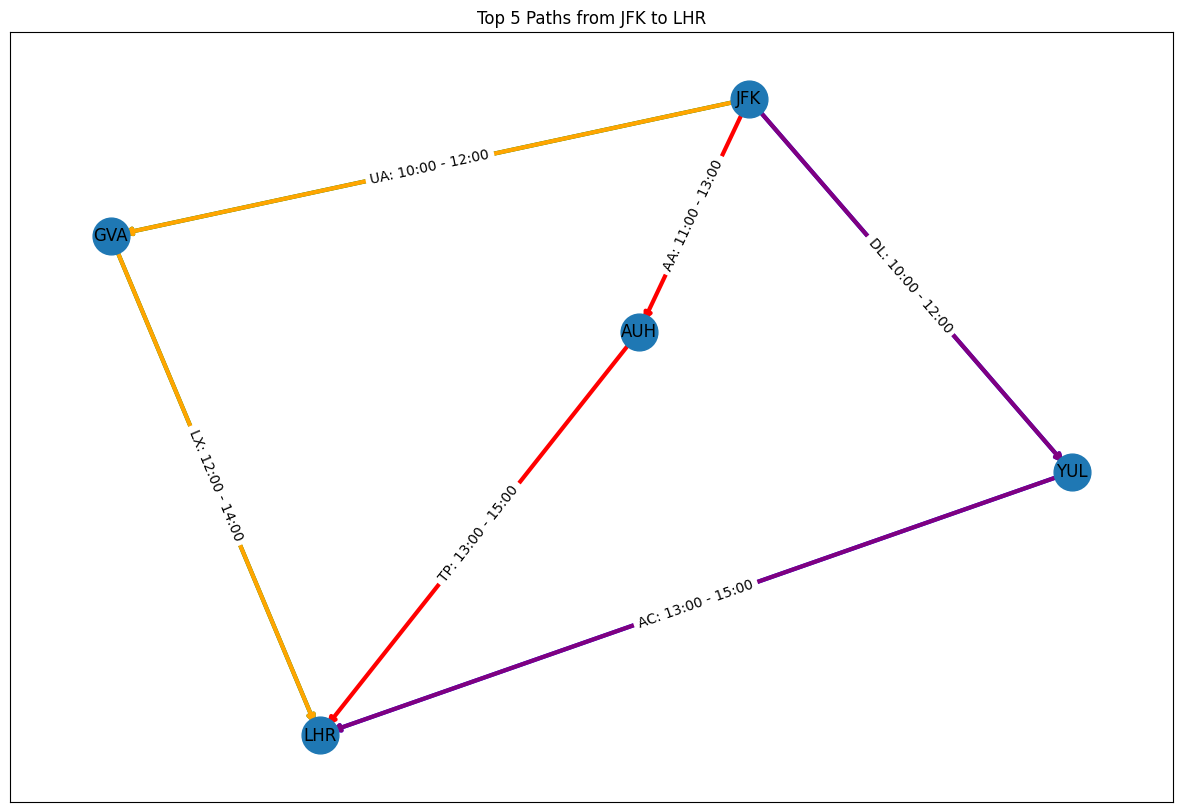

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Mapping function
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):

            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time, row['Airline'])))
    return results

# Calculate total flight time excluding layovers
def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr, _ in path_times], datetime.timedelta())

# Reduce function to find all paths
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time, flight_times))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time, airline = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(
                    next_airport,
                    current_path + [next_airport],
                    arr_time,
                    total_time + (arr_time - current_time),
                    flight_times + [(dep_time, arr_time, airline)],
                    start_time,
                    visited.copy()
                )
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Exclude direct paths and sort paths by the number of stops (ascending)
    all_routes_filtered = [route for route in all_routes if len(route[0]) > 2]
    all_routes_sorted = sorted(all_routes_filtered, key=lambda x: x[1])  # Sort by total travel time
    return all_routes_sorted

# Visualize paths using NetworkX and Matplotlib
def visualize_paths(paths, title="Top 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

# Print paths
if reduced_data:
    optimal_path = reduced_data[0]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(reduced_data, 1):
        optimal_str = " (Optimal Path)" if path == optimal_path[0] else ""
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}{optimal_str}")
    print("\nTop 5 Indirect Paths with the Fewest Stops:")
    top_5_paths = reduced_data[:5]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(top_5_paths, 1):
        print(f"Top Path {idx}: {path} - Total Stops: {len(path) - 2}, Total Travel Time: {total_time}, "
              f"Flight Time: {flight_time}, Start Time: {start}, End Time: {end}")
    visualize_paths(top_5_paths, f"Top 5 Paths from {src_airport} to {dst_airport}")
else:
    print(f"No indirect paths found from {src_airport} to {dst_airport} within the specified time frame.")


Including direct path , sort basis of total time

Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 2:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 12:00:00 (Optimal Path)
Path 2 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 3:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 13:00:00 (Optimal Path)
Path 3 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00 (Optimal Path)
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 5 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End 

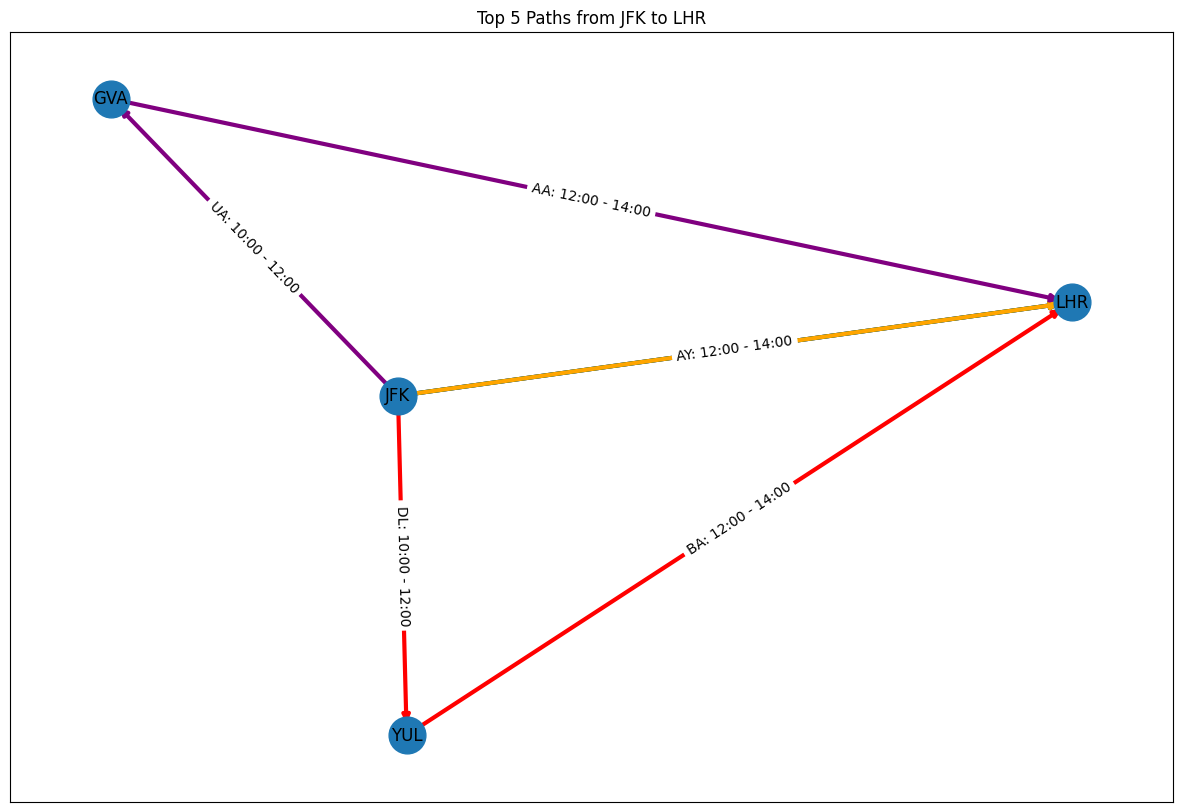

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Mapping function
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time, row['Airline'])))
    return results

# Calculate total flight time excluding layovers
def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr, _ in path_times], datetime.timedelta())

# Reduce function to find all paths
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time, flight_times))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time, airline = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(
                    next_airport,
                    current_path + [next_airport],
                    arr_time,
                    total_time + (arr_time - current_time),
                    flight_times + [(dep_time, arr_time, airline)],
                    start_time,
                    visited.copy()
                )
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Sort paths by total travel time (including direct paths)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[1])
    return all_routes_sorted

# Visualize paths using NetworkX and Matplotlib
def visualize_paths(paths, title="Top 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

# Print paths
if reduced_data:
    optimal_path = reduced_data[0]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(reduced_data, 1):
        optimal_str = " (Optimal Path)" if path == optimal_path[0] else ""
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}{optimal_str}")
    print("\nTop 5 Paths with the Shortest Total Travel Time:")
    top_5_paths = reduced_data[:5]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(top_5_paths, 1):
        print(f"Top Path {idx}: {path} - Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}")
    visualize_paths(top_5_paths, f"Top 5 Paths from {src_airport} to {dst_airport}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Showing graph for Optimal, top 5 and Least 5 Paths

Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 2:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 12:00:00 (Optimal Path)
Path 2 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 3:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 13:00:00 (Optimal Path)
Path 3 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00 (Optimal Path)
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 5 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End 

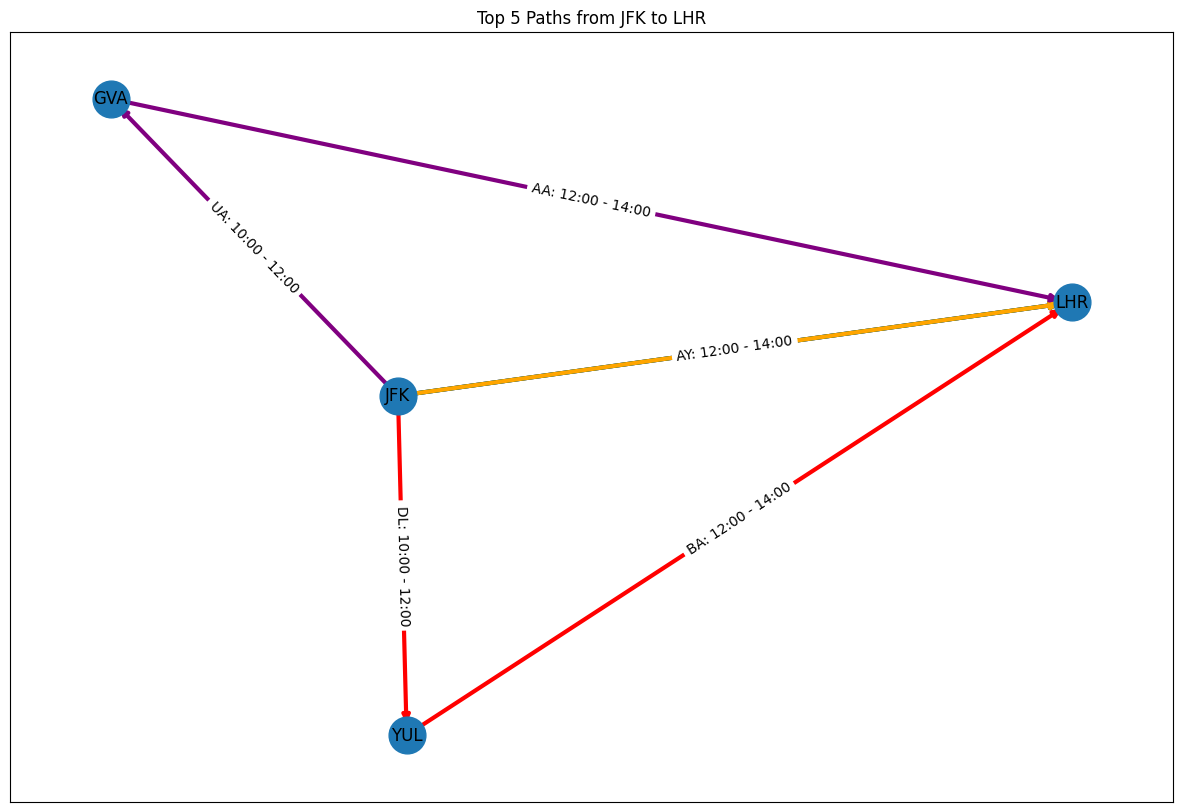

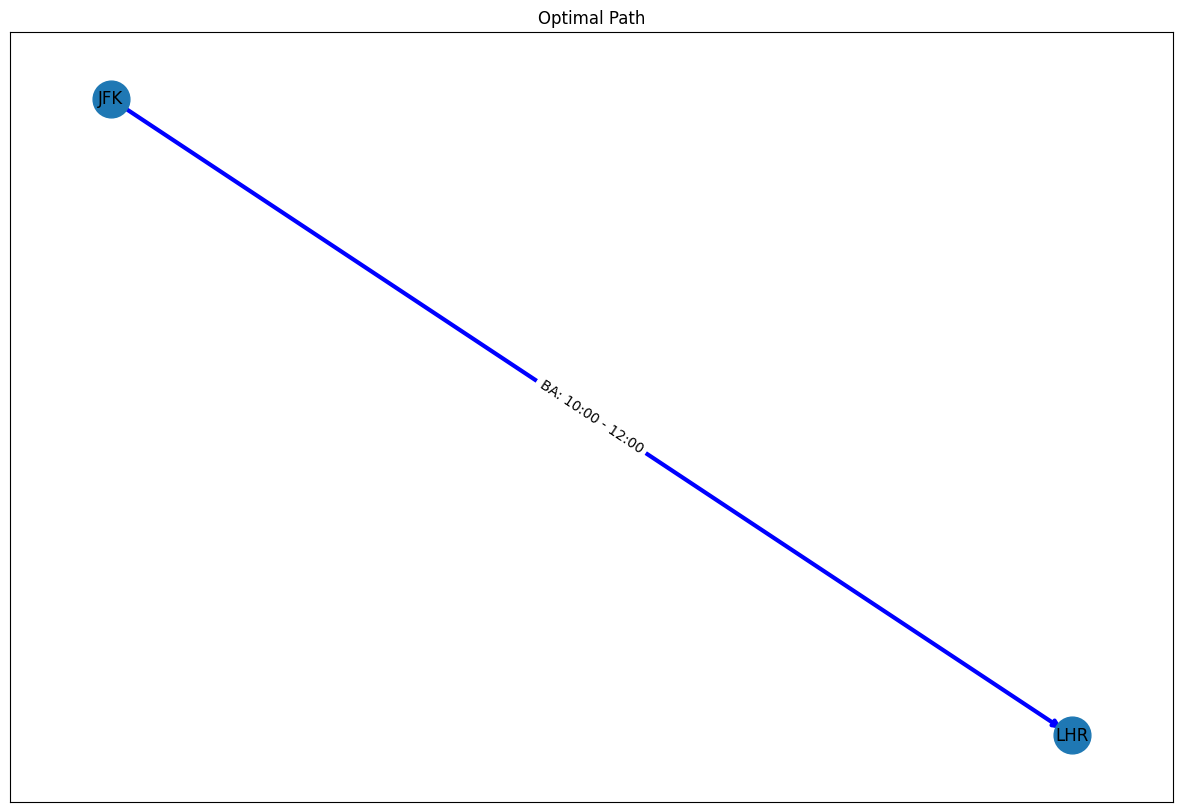


Worst 5 Paths with the Longest Total Travel Time:
Worst Path 1: ['JFK', 'SVO', 'TAS', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 6:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Worst Path 2: ['JFK', 'GVA', 'BRU', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 6:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Worst Path 3: ['JFK', 'GVA', 'LIS', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 6:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Worst Path 4: ['JFK', 'CMH', 'ATL', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 6:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00
Worst Path 5: ['JFK', 'PEK', 'VIE', 'LHR'] - Total Travel Time: 6:00:00, Flight Time: 6:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 16:00:00


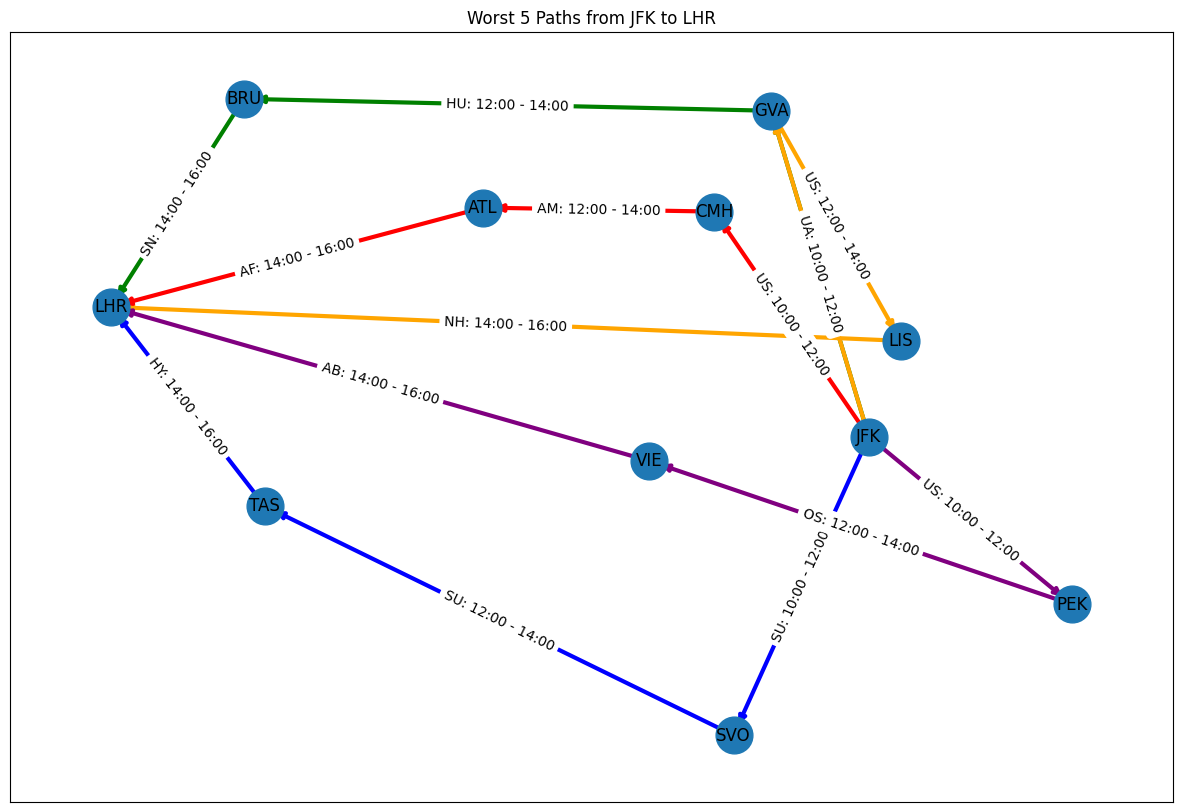

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Mapping function
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time, row['Airline'])))
    return results

# Calculate total flight time excluding layovers
def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr, _ in path_times], datetime.timedelta())

# Reduce function to find all paths
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time, flight_times))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time, airline = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(
                    next_airport,
                    current_path + [next_airport],
                    arr_time,
                    total_time + (arr_time - current_time),
                    flight_times + [(dep_time, arr_time, airline)],
                    start_time,
                    visited.copy()
                )
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Sort paths by total travel time (including direct paths)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[1])
    return all_routes_sorted

# Visualize paths using NetworkX and Matplotlib
def visualize_paths(paths, title="Top 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

def visualize_optimal_path(optimal_path):
    G = nx.DiGraph()
    edge_labels = {}

    for i in range(len(optimal_path[0]) - 1):
        src, dst = optimal_path[0][i], optimal_path[0][i + 1]
        dep_time, arr_time, airline = optimal_path[5][i]
        G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
        edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    path_edges = list(zip(optimal_path[0], optimal_path[0][1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="blue", width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Optimal Path")
    plt.show()

def visualize_worst_paths(paths, title="Worst 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

# Print paths
if reduced_data:
    optimal_path = reduced_data[0]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(reduced_data, 1):
        optimal_str = " (Optimal Path)" if path == optimal_path[0] else ""
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}{optimal_str}")

    print("\nTop 5 Paths with the Shortest Total Travel Time:")
    top_5_paths = reduced_data[:5]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(top_5_paths, 1):
        print(f"Top Path {idx}: {path} - Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}")
    visualize_paths(top_5_paths, f"Top 5 Paths from {src_airport} to {dst_airport}")
    visualize_optimal_path(optimal_path)

    worst_5_paths = reduced_data[-5:]
    print("\nWorst 5 Paths with the Longest Total Travel Time:")
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(worst_5_paths, 1):
        print(f"Worst Path {idx}: {path} - Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}")
    visualize_worst_paths(worst_5_paths, f"Worst 5 Paths from {src_airport} to {dst_airport}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Showing all the Routes (Graph Intitally)

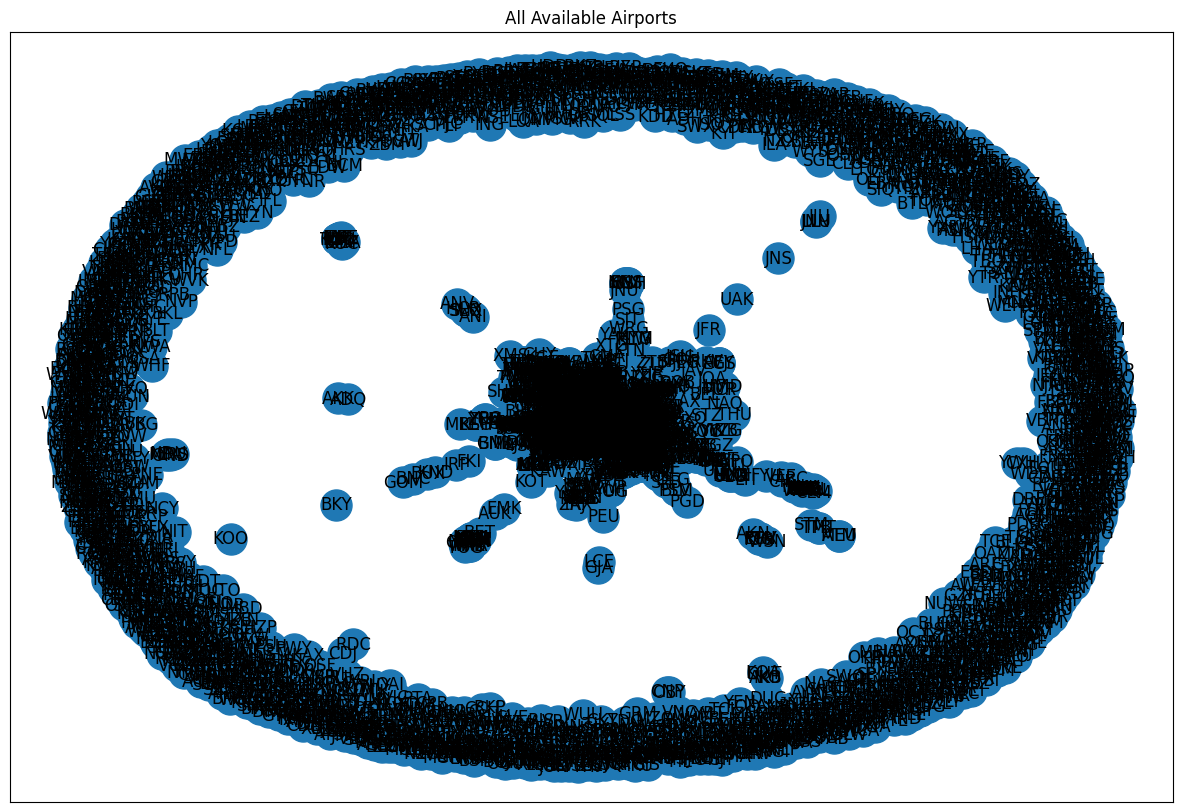

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Mapping function
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time, row['Airline'])))
    return results

# Calculate total flight time excluding layovers
def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr, _ in path_times], datetime.timedelta())

# Reduce function to find all paths
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time, flight_times))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time, airline = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(
                    next_airport,
                    current_path + [next_airport],
                    arr_time,
                    total_time + (arr_time - current_time),
                    flight_times + [(dep_time, arr_time, airline)],
                    start_time,
                    visited.copy()
                )
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Sort paths by total travel time (including direct paths)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[1])
    return all_routes_sorted

# Visualize simplified version of all flights graph
def visualize_all_routes_simple(G, title="All Available Airports"):
    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_labels(G, pos)
    plt.title(title)
    plt.show()

# Visualize paths using NetworkX and Matplotlib
def visualize_paths(paths, title="Top 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

def visualize_optimal_path(optimal_path):
    G = nx.DiGraph()
    edge_labels = {}

    for i in range(len(optimal_path[0]) - 1):
        src, dst = optimal_path[0][i], optimal_path[0][i + 1]
        dep_time, arr_time, airline = optimal_path[5][i]
        G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
        edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    path_edges = list(zip(optimal_path[0], optimal_path[0][1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="blue", width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Optimal Path")
    plt.show()

def visualize_worst_paths(paths, title="Worst 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# Create graph with all available flights
G = nx.DiGraph()
for idx, row in airports.iterrows():
    G.add_node(row['IATA'], name=row['Name'], city=row['City'], country=row['Country'], label=f"{row['IATA']} ({row['City']})")

for idx, row in routes.iterrows():
    if row['Src_Airport'] in G and row['Dst_Airport'] in G:
        G.add_edge(row['Src_Airport'], row['Dst_Airport'], label=row['Airline'])

visualize_all_routes_simple(G)

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

# Print paths
if reduced_data:
    optimal_path = reduced_data[0]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(reduced_data, 1):
        optimal_str = " (Optimal Path)" if idx == 1 else ""
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}{optimal_str}")

    # Visualizations
    top_5_paths = reduced_data[:5]
    worst_5_paths = reduced_data[-5:]
    visualize_paths(top_5_paths, f"Top 5 Paths from {src_airport} to {dst_airport}")
    visualize_optimal_path(optimal_path)
    visualize_worst_paths(worst_5_paths, f"Worst 5 Paths from {src_airport} to {dst_airport}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Showing graph of all the path shown

Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 2:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 12:00:00
Path 2 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 3:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 13:00:00
Path 3 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 5 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Optimal Path: ['JFK

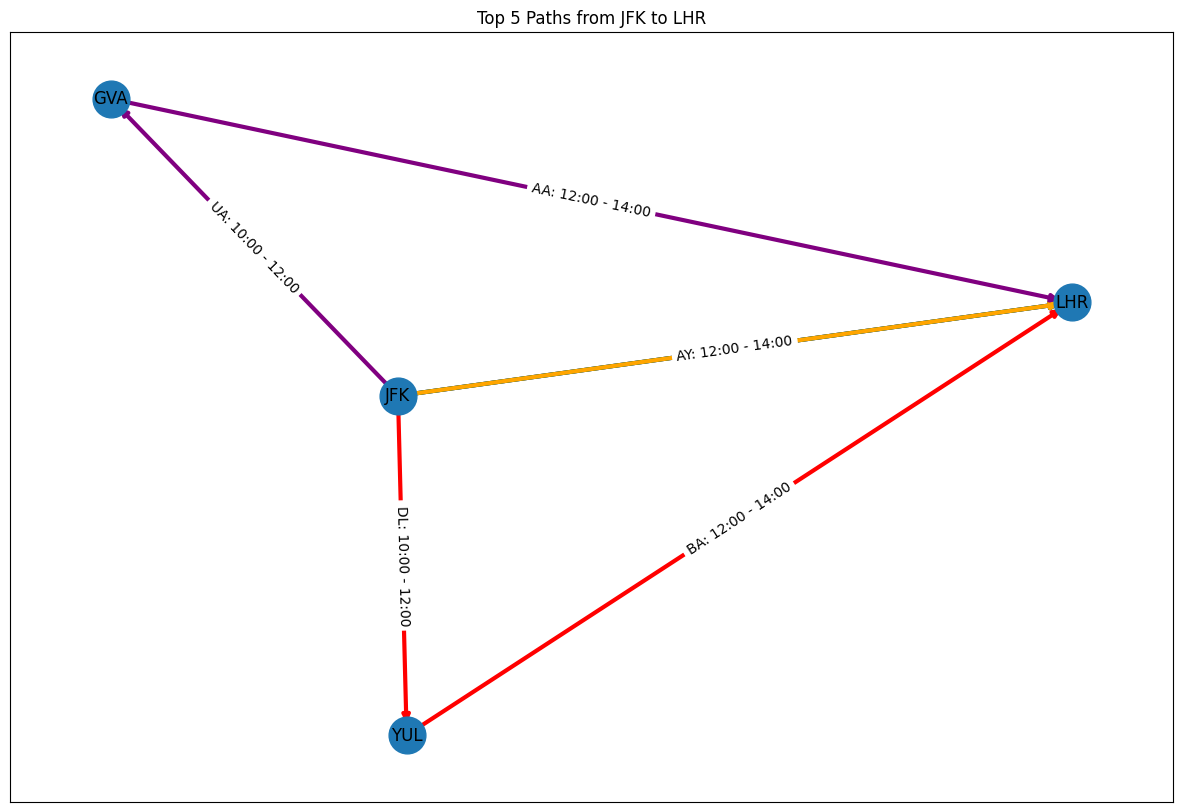

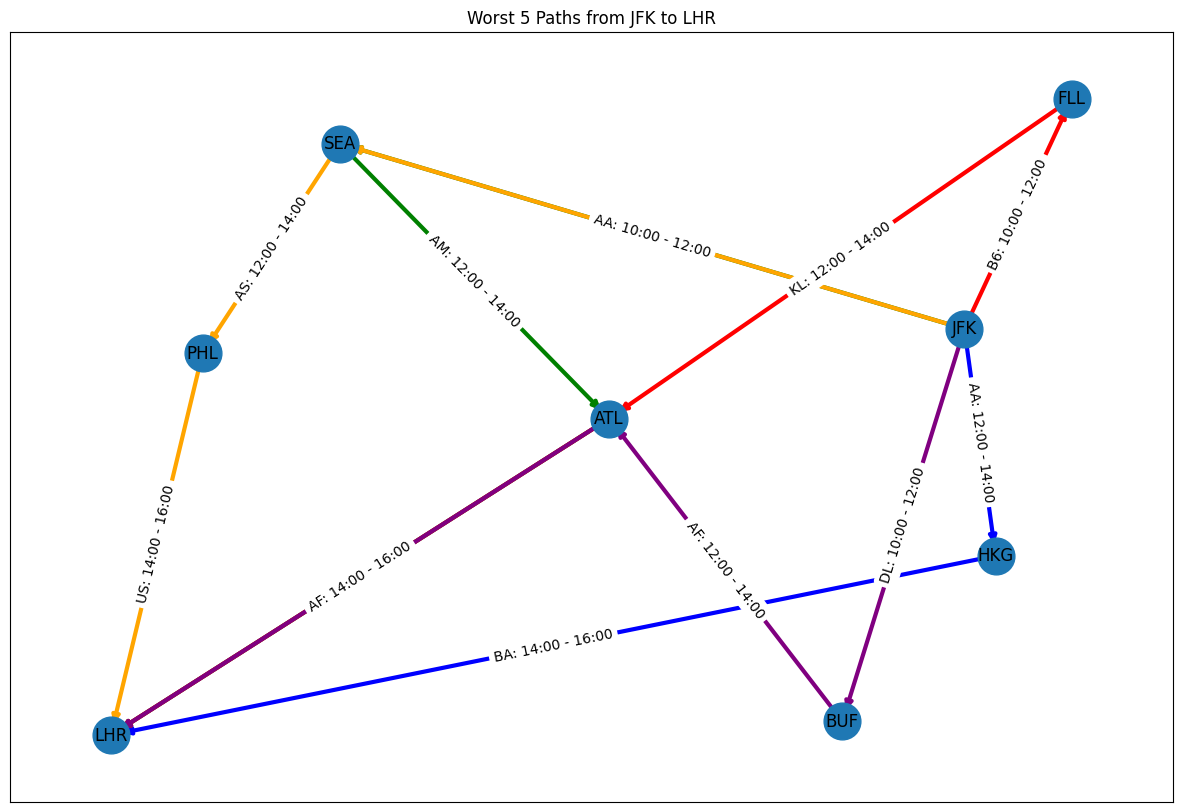

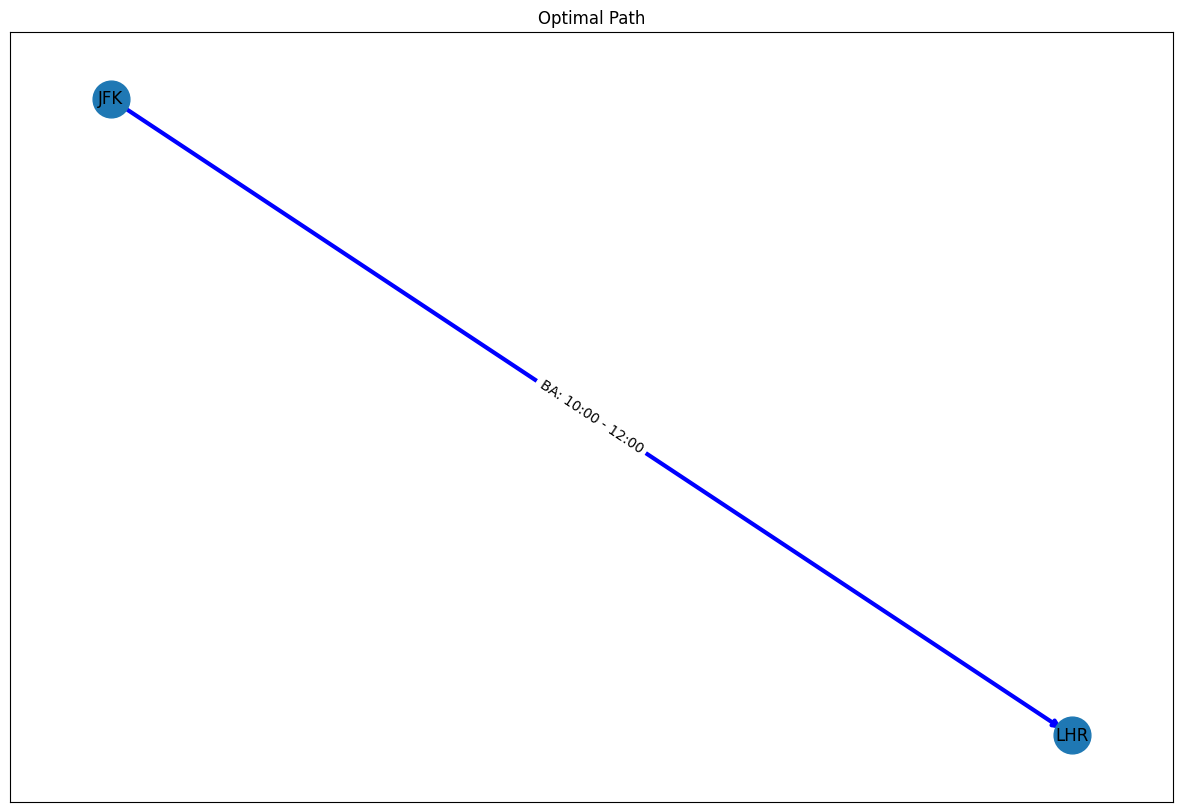

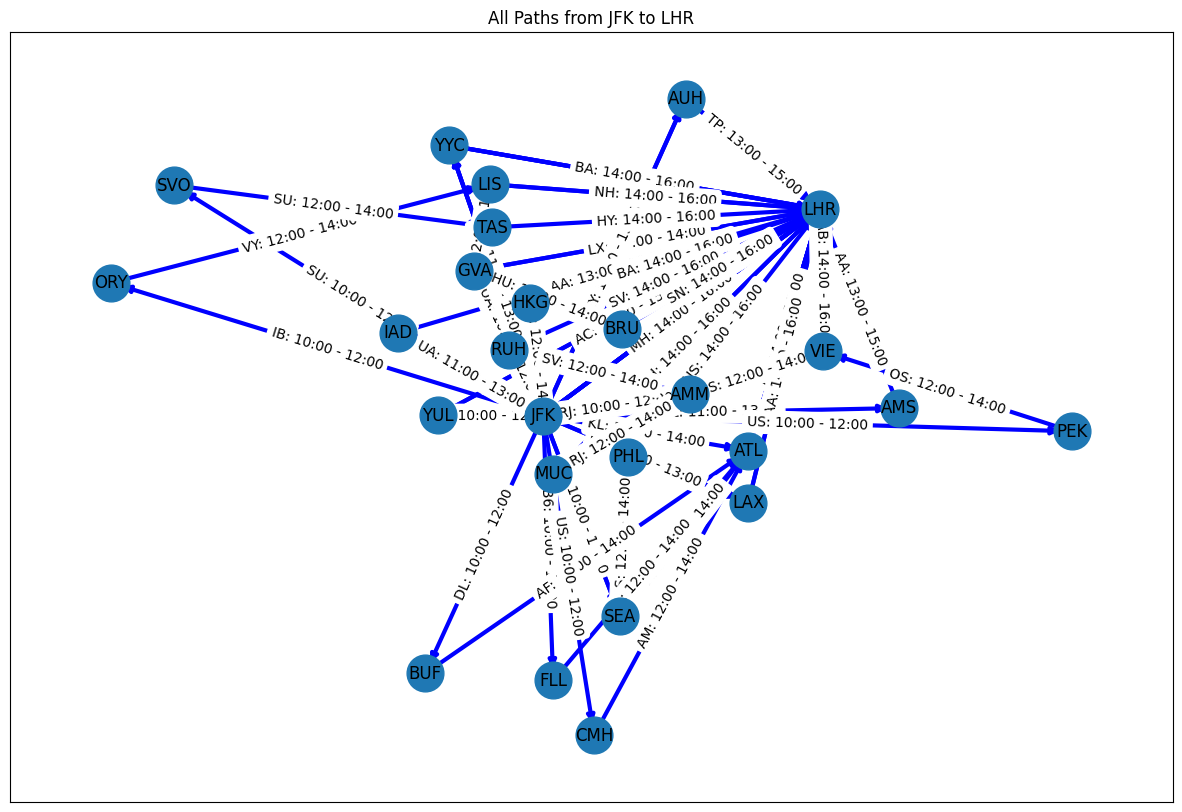

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Mapping function
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        departure_time = start_time + datetime.timedelta(hours=(index % 24))
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time, row['Airline'])))
    return results

# Calculate total flight time excluding layovers
def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr, _ in path_times], datetime.timedelta())

# Reduce function to find all paths
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time, flight_times))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time, airline = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(
                    next_airport,
                    current_path + [next_airport],
                    arr_time,
                    total_time + (arr_time - current_time),
                    flight_times + [(dep_time, arr_time, airline)],
                    start_time,
                    visited.copy()
                )
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Sort paths by total travel time (including direct paths)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[1])
    return all_routes_sorted

# Visualize paths using NetworkX and Matplotlib
def visualize_paths(paths, title="Top 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

def visualize_all_paths(all_paths, title="All Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in all_paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    path_edges = [list(zip(path[0], path[0][1:])) for path in all_paths]
    all_path_edges = [edge for edges in path_edges for edge in edges]
    nx.draw_networkx_edges(G, pos, edgelist=all_path_edges, edge_color="blue", width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

def visualize_optimal_path(optimal_path):
    G = nx.DiGraph()
    edge_labels = {}

    for i in range(len(optimal_path[0]) - 1):
        src, dst = optimal_path[0][i], optimal_path[0][i + 1]
        dep_time, arr_time, airline = optimal_path[5][i]
        G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
        edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    path_edges = list(zip(optimal_path[0], optimal_path[0][1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="blue", width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Optimal Path")
    plt.show()

def visualize_worst_paths(paths, title="Worst 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

# Print paths
if reduced_data:
    optimal_path = reduced_data[0]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(reduced_data[:5], start=1):
        print(
            f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
            f"Total Travel Time: {total_time}, Flight Time: {flight_time}, "
            f"Start Time: {start}, End Time: {end}")
    print(f"Optimal Path: {optimal_path[0]} - Total Travel Time: {optimal_path[1]}, Flight Time: {optimal_path[2]}")

    worst_5_paths = sorted(reduced_data, key=lambda x: x[1], reverse=True)[:5]

    visualize_paths(reduced_data[:5], f"Top 5 Paths from {src_airport} to {dst_airport}")
    visualize_worst_paths(worst_5_paths, f"Worst 5 Paths from {src_airport} to {dst_airport}")
    visualize_optimal_path(optimal_path)
    visualize_all_paths(reduced_data, f"All Paths from {src_airport} to {dst_airport}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Trying to make it more feasible

1. Load Data Once and Use Efficiently:
Load data only once and reuse it across multiple paths.
Make use of efficient data structures like defaultdict for fast lookups.
2. Input Validation and Error Handling:
Validate user inputs to avoid unexpected errors.
Provide informative error messages.
3. Graph Optimization:
Precompute and store flight connections between airports for fast access.
Index flight data by source airports for fast lookup.
4. Reduce Graph Visualization Overhead:
Reduce the node and edge count to simplify visualization.
5. Optional Features:
Allow users to enable or disable graph visualization for large path sets.

Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 4
Path 1 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 2:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 12:00:00 (Optimal Path)
Path 2 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 3:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 13:00:00 (Optimal Path)
Path 3 found from JFK to LHR: ['JFK', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 2:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00 (Optimal Path)
Path 4 found from JFK to LHR: ['JFK', 'YUL', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End Time: 2021-01-01 14:00:00
Path 5 found from JFK to LHR: ['JFK', 'GVA', 'LHR'] - Total Travel Time: 4:00:00, Flight Time: 4:00:00, Start Time: 2021-01-01 10:00:00, End 

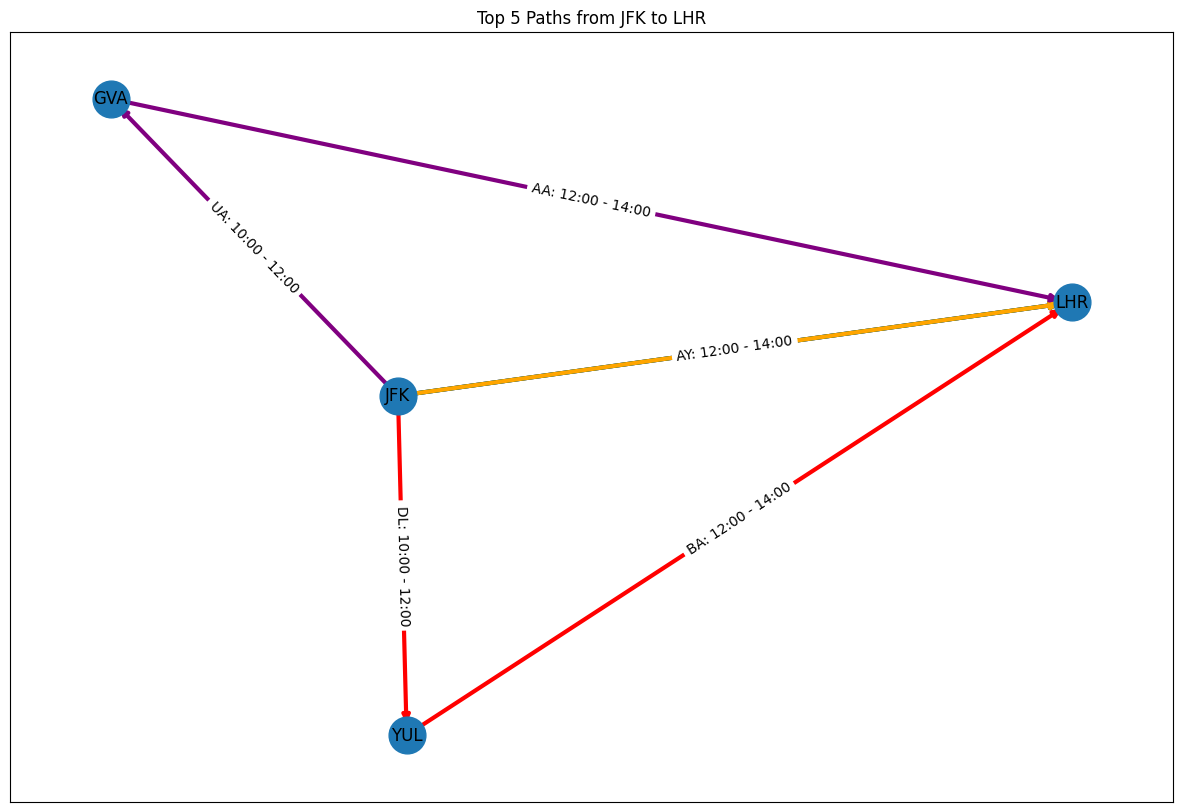

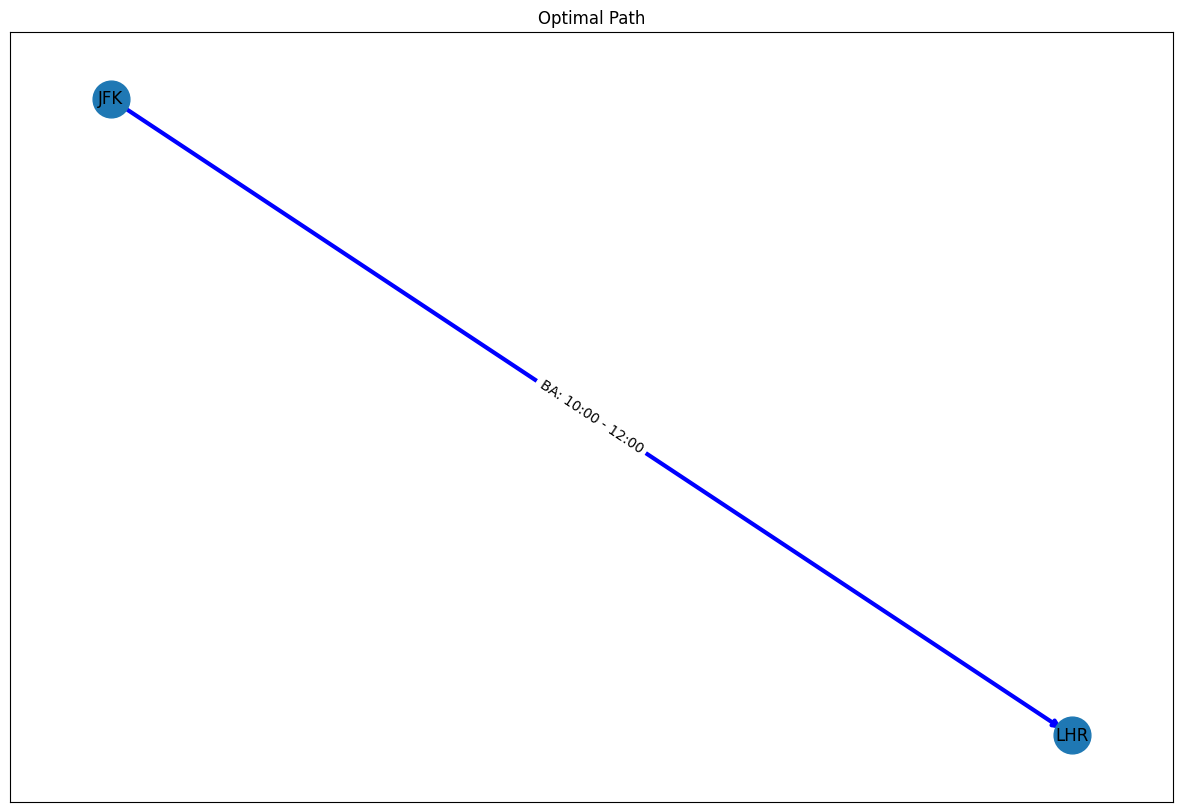

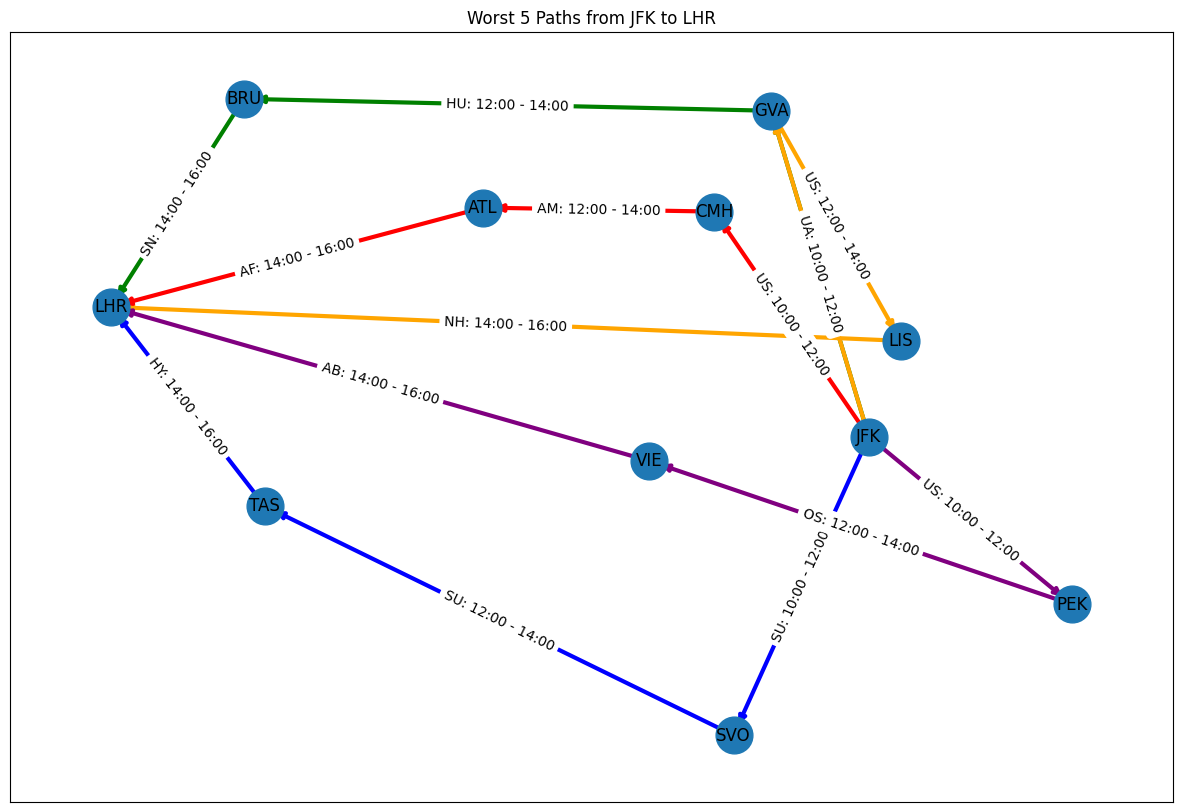

In [ ]:
import pandas as pd
import datetime
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Mapping function
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        # Generate consistent departure times throughout the day
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)  # Assuming a flight duration of 2 hours
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time, row['Airline'])))
    return results

# Calculate total flight time excluding layovers
def calculate_total_flight_time(path_times):
    return sum([arr - dep for dep, arr, _ in path_times], datetime.timedelta())

# Reduce function to find all paths
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    all_routes = []

    def find_paths(start_airport, current_path, current_time, total_time, flight_times, start_time, visited):
        if start_airport == dst_airport:
            total_flight_time = calculate_total_flight_time(flight_times)
            all_routes.append((current_path, total_time, total_flight_time, start_time, current_time, flight_times))
            return
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time, airline = flight
            if next_airport not in visited and current_time <= dep_time:
                find_paths(
                    next_airport,
                    current_path + [next_airport],
                    arr_time,
                    total_time + (arr_time - current_time),
                    flight_times + [(dep_time, arr_time, airline)],
                    start_time,
                    visited.copy()
                )
        visited.remove(start_airport)

    find_paths(src_airport, [src_airport], input_start_time, datetime.timedelta(), [], input_start_time, set())

    # Sort paths by total travel time (including direct paths)
    all_routes_sorted = sorted(all_routes, key=lambda x: x[1])
    return all_routes_sorted

# Visualize paths using NetworkX and Matplotlib
def visualize_paths(paths, title="Top 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

def visualize_optimal_path(optimal_path):
    G = nx.DiGraph()
    edge_labels = {}

    for i in range(len(optimal_path[0]) - 1):
        src, dst = optimal_path[0][i], optimal_path[0][i + 1]
        dep_time, arr_time, airline = optimal_path[5][i]
        G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
        edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    path_edges = list(zip(optimal_path[0], optimal_path[0][1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="blue", width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Optimal Path")
    plt.show()

def visualize_worst_paths(paths, title="Worst 5 Paths"):
    G = nx.DiGraph()
    edge_labels = {}

    for path in paths:
        for i in range(len(path[0]) - 1):
            src, dst = path[0][i], path[0][i + 1]
            dep_time, arr_time, airline = path[5][i]
            G.add_edge(src, dst, weight=1, label=f"{airline}: {dep_time.strftime('%H:%M')} - {arr_time.strftime('%H:%M')}")
            edge_labels[(src, dst)] = G[src][dst]['label']

    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos)

    for i, path in enumerate(paths):
        edge_colors = ["blue", "green", "orange", "red", "purple"]
        path_edges = list(zip(path[0], path[0][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=edge_colors[i], width=3)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=[
    'ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=[
    'Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID',
    'Codeshare', 'Stops', 'Equipment'])

# User inputs
src_airport = input("Enter source airport IATA code: ")
dst_airport = input("Enter destination airport IATA code: ")
input_time = input("Enter start time (HH:MM, 24-hour format): ")
duration_hours = int(input("Enter duration of time window in hours: "))

# Convert input_time to a datetime object
input_start_time = datetime.datetime.strptime(f"2021-01-01 {input_time}", "%Y-%m-%d %H:%M")

# Mapping and reducing
mapped_data = map_flights(routes, input_start_time, duration_hours)
reduced_data = reduce_flights(mapped_data, src_airport, dst_airport, input_start_time)

# Print paths
if reduced_data:
    optimal_path = reduced_data[0]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(reduced_data, 1):
        optimal_str = " (Optimal Path)" if path == optimal_path[0] else ""
        print(f"Path {idx} found from {src_airport} to {dst_airport}: {path} - "
              f"Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}{optimal_str}")

    print("\nTop 5 Paths with the Shortest Total Travel Time:")
    top_5_paths = reduced_data[:5]
    for idx, (path, total_time, flight_time, start, end, flight_times) in enumerate(top_5_paths, 1):
        print(f"Path {idx} - {path} - Total Travel Time: {total_time}, Flight Time: {flight_time}, "
              f"Start Time: {start}, End Time: {end}")

    visualize_paths(top_5_paths, f"Top 5 Paths from {src_airport} to {dst_airport}")
    visualize_optimal_path(optimal_path)

    worst_5_paths = reduced_data[-5:]
    visualize_worst_paths(worst_5_paths, f"Worst 5 Paths from {src_airport} to {dst_airport}")
else:
    print(f"No paths found from {src_airport} to {dst_airport} within the specified time frame.")


Comparing A* and MapReduce

Enter source airport IATA code: JFK
Enter destination airport IATA code: LHR
Enter start time (HH:MM, 24-hour format): 08:00
Enter duration of time window in hours: 4
Optimal path using A*: ['JFK', 'DUB', 'NCL', 'DUS', 'LHR']
Optimal path using MapReduce: ['JFK', 'AUH', 'LHR']


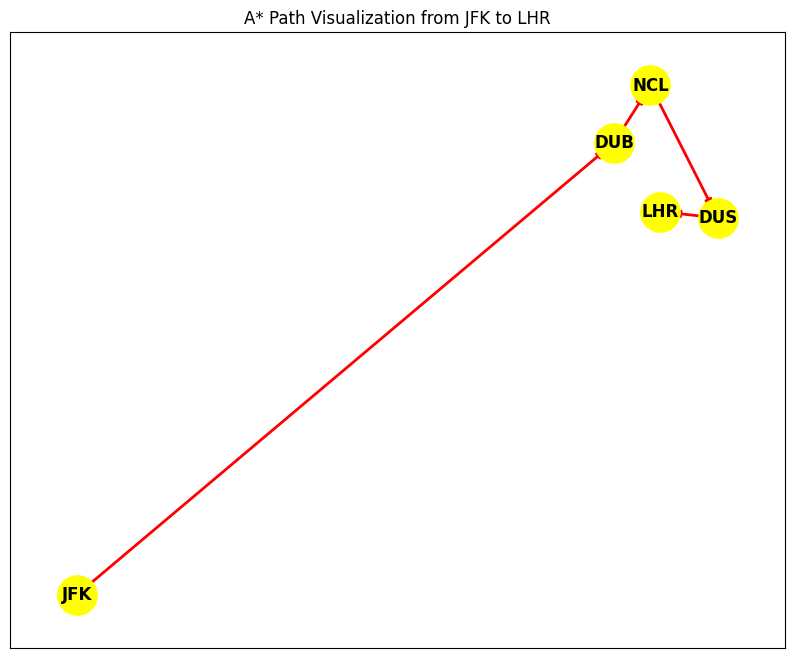

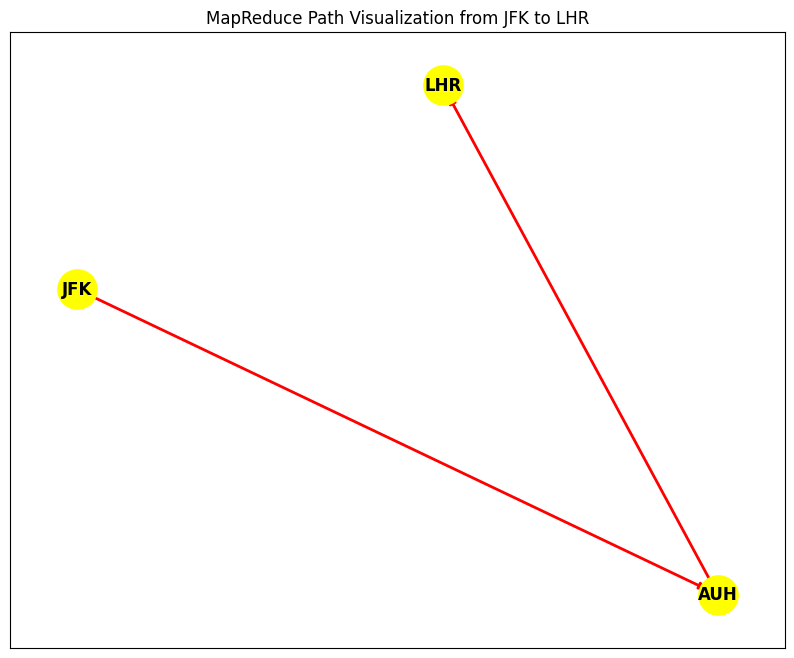

In [ ]:
import pandas as pd
import networkx as nx
import heapq
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID', 'Codeshare', 'Stops', 'Equipment'])

# Create a directed graph
G = nx.DiGraph()

# Add airports as nodes with geographic coordinates
for idx, row in airports.iterrows():
    if pd.notna(row['IATA']) and pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        G.add_node(row['IATA'], id=row['ID'], name=row['Name'], city=row['City'], country=row['Country'], Latitude=row['Latitude'], Longitude=row['Longitude'])

# Add routes as edges with simulated departure times
base_time = datetime.datetime(2021, 1, 1, 6, 0)
for idx, row in routes.iterrows():
    if row['Src_Airport'] in G and row['Dst_Airport'] in G:
        departure_time = base_time + datetime.timedelta(hours=(idx % 24))
        arrival_time = departure_time + datetime.timedelta(hours=2)
        G.add_edge(row['Src_Airport'], row['Dst_Airport'], departure_time=departure_time, arrival_time=arrival_time)

# Heuristic function
def heuristic(node, end_node, graph):
    try:
        node_lat_long = (graph.nodes[node]['Latitude'], graph.nodes[node]['Longitude'])
        end_lat_long = (graph.nodes[end_node]['Latitude'], graph.nodes[end_node]['Longitude'])
        return ((node_lat_long[0] - end_lat_long[0])**2 + (node_lat_long[1] - end_lat_long[1])**2)**0.5
    except KeyError:
        return float('inf')

# A* Heuristic Pathfinding
def a_star_search(graph, start, end, start_time, end_time):
    open_set = []
    heapq.heappush(open_set, (0, start, [start], start_time))
    visited = {}

    while open_set:
        _, current, path, current_time = heapq.heappop(open_set)

        if current in visited and visited[current] <= current_time:
            continue
        visited[current] = current_time

        if current == end:
            return path  # Return the optimal path

        for neighbor in graph.neighbors(current):
            flight = graph.get_edge_data(current, neighbor)
            if flight and 'departure_time' in flight:
                next_time = flight['departure_time']
                if current_time <= next_time <= end_time:
                    new_path = path + [neighbor]
                    cost = len(new_path)
                    heuristic_cost = heuristic(neighbor, end, graph)
                    heapq.heappush(open_set, (cost + heuristic_cost, neighbor, new_path, next_time))

    return None

# MapReduce Algorithm
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

mapped_data = map_flights(routes, base_time, 6)

# Reduce function (simplified)
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    def find_paths(start_airport, current_path, current_time, visited):
        if start_airport == dst_airport:
            return current_path
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                result = find_paths(next_airport, current_path + [next_airport], arr_time, visited)
                if result:
                    return result
        visited.remove(start_airport)
        return None

    return find_paths(src_airport, [src_airport], input_start_time, set())

# Visualization Function
def visualize_path(graph, path, title="Path Visualization"):
    pos = {node: (graph.nodes[node]['Longitude'], graph.nodes[node]['Latitude']) for node in path if node in graph.nodes and 'Longitude' in graph.nodes[node] and 'Latitude' in graph.nodes[node]}
    filtered_path = [node for node in path if node in pos]
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(graph, pos, nodelist=filtered_path, node_color='yellow', node_size=800)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(filtered_path, filtered_path[1:])), edge_color='red', width=2)
    nx.draw_networkx_labels(graph, pos, labels={node: node for node in filtered_path}, font_weight='bold')
    plt.title(title)
    plt.show()

# User Input Section
source = input("Enter source airport IATA code: ").strip().upper()
destination = input("Enter destination airport IATA code: ").strip().upper()
start_time_str = input("Enter start time (HH:MM, 24-hour format): ").strip()
duration_hours = int(input("Enter duration of time window in hours: ").strip())

# Convert user-provided time to datetime
start_time = datetime.datetime.strptime(start_time_str, "%H:%M")
start_time = base_time.replace(hour=start_time.hour, minute=start_time.minute)
end_time = start_time + datetime.timedelta(hours=duration_hours)

# Run A* and MapReduce searches
path_a_star = a_star_search(G, source, destination, start_time, end_time)
mapped_data = map_flights(routes, start_time, duration_hours)
path_mapreduce = reduce_flights(mapped_data, source, destination, start_time)

# Print and visualize results
print(f"Optimal path using A*: {path_a_star}")
print(f"Optimal path using MapReduce: {path_mapreduce}")

if path_a_star:
    visualize_path(G, path_a_star, title=f"A* Path Visualization from {source} to {destination}")
if path_mapreduce:
    visualize_path(G, path_mapreduce, title=f"MapReduce Path Visualization from {source} to {destination}")


Comparing the Execution time

In [ ]:
import pandas as pd
import networkx as nx
import heapq
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import time

# Load data
airports = pd.read_csv('airports.dat.txt', header=None, names=['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'TZ', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline_ID', 'Src_Airport', 'Src_ID', 'Dst_Airport', 'Dst_ID', 'Codeshare', 'Stops', 'Equipment'])

# Create a directed graph
G = nx.DiGraph()

# Add airports as nodes with geographic coordinates
for idx, row in airports.iterrows():
    if pd.notna(row['IATA']) and pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        G.add_node(row['IATA'], id=row['ID'], name=row['Name'], city=row['City'], country=row['Country'], Latitude=row['Latitude'], Longitude=row['Longitude'])

# Add routes as edges with simulated departure times
base_time = datetime.datetime(2021, 1, 1, 6, 0)
for idx, row in routes.iterrows():
    if row['Src_Airport'] in G and row['Dst_Airport'] in G:
        departure_time = base_time + datetime.timedelta(hours=(idx % 24))
        arrival_time = departure_time + datetime.timedelta(hours=2)
        G.add_edge(row['Src_Airport'], row['Dst_Airport'], departure_time=departure_time, arrival_time=arrival_time)

# Heuristic function
def heuristic(node, end_node, graph):
    try:
        node_lat_long = (graph.nodes[node]['Latitude'], graph.nodes[node]['Longitude'])
        end_lat_long = (graph.nodes[end_node]['Latitude'], graph.nodes[end_node]['Longitude'])
        return ((node_lat_long[0] - end_lat_long[0])**2 + (node_lat_long[1] - end_lat_long[1])**2)**0.5
    except KeyError:
        return float('inf')

# A* Heuristic Pathfinding
def a_star_search(graph, start, end, start_time, end_time):
    open_set = []
    heapq.heappush(open_set, (0, start, [start], start_time))
    visited = {}

    while open_set:
        _, current, path, current_time = heapq.heappop(open_set)

        if current in visited and visited[current] <= current_time:
            continue
        visited[current] = current_time

        if current == end:
            return path  # Return the optimal path

        for neighbor in graph.neighbors(current):
            flight = graph.get_edge_data(current, neighbor)
            if flight and 'departure_time' in flight:
                next_time = flight['departure_time']
                if current_time <= next_time <= end_time:
                    new_path = path + [neighbor]
                    cost = len(new_path)
                    heuristic_cost = heuristic(neighbor, end, graph)
                    heapq.heappush(open_set, (cost + heuristic_cost, neighbor, new_path, next_time))

    return None

# MapReduce Algorithm
def map_flights(data, start_time, duration_hours):
    results = []
    for index, row in data.iterrows():
        departure_time = start_time + datetime.timedelta(hours=index % 24)
        arrival_time = departure_time + datetime.timedelta(hours=2)
        if start_time <= departure_time <= (start_time + datetime.timedelta(hours=duration_hours)):
            results.append((row['Src_Airport'], (row['Dst_Airport'], departure_time, arrival_time)))
    return results

# Reduce function (simplified)
def reduce_flights(mapped_data, src_airport, dst_airport, input_start_time):
    routes_from_airport = defaultdict(list)
    for key, value in mapped_data:
        routes_from_airport[key].append(value)

    def find_paths(start_airport, current_path, current_time, visited):
        if start_airport == dst_airport:
            return current_path
        visited.add(start_airport)
        for flight in routes_from_airport.get(start_airport, []):
            next_airport, dep_time, arr_time = flight
            if next_airport not in visited and current_time <= dep_time:
                result = find_paths(next_airport, current_path + [next_airport], arr_time, visited)
                if result:
                    return result
        visited.remove(start_airport)
        return None

    return find_paths(src_airport, [src_airport], input_start_time, set())

# Scalability Function
def compare_scalability(graph, mapped_data, source, destination, start_time, end_time):
    # A* Algorithm
    start_a_star = time.time()
    path_a_star = a_star_search(graph, source, destination, start_time, end_time)
    end_a_star = time.time()

    # MapReduce Algorithm
    start_mapreduce = time.time()
    path_mapreduce = reduce_flights(mapped_data, source, destination, start_time)
    end_mapreduce = time.time()

    print(f"Optimal path using A*: {path_a_star}")
    print(f"Optimal path using MapReduce: {path_mapreduce}")
    print(f"Time taken by A* Algorithm: {end_a_star - start_a_star:.4f} seconds")
    print(f"Time taken by MapReduce Algorithm: {end_mapreduce - start_mapreduce:.4f} seconds")

# User Input Section
source = input("Enter source airport IATA code: ").strip().upper()
destination = input("Enter destination airport IATA code: ").strip().upper()
start_time_str = input("Enter start time (HH:MM, 24-hour format): ").strip()
duration_hours = int(input("Enter duration of time window in hours: ").strip())

# Convert user-provided time to datetime
start_time = datetime.datetime.strptime(start_time_str, "%H:%M")
start_time = base_time.replace(hour=start_time.hour, minute=start_time.minute)
end_time = start_time + datetime.timedelta(hours=duration_hours)

# Generate Mapped Data
mapped_data = map_flights(routes, start_time, duration_hours)

# Compare Scalability
compare_scalability(G, mapped_data, source, destination, start_time, end_time)


Enter source airport IATA code: ORD
Enter destination airport IATA code: DEN
Enter start time (HH:MM, 24-hour format): 10:00
Enter duration of time window in hours: 1
Optimal path using A*: ['ORD', 'MCO', 'SFO', 'IAH', 'DEN']
Optimal path using MapReduce: ['ORD', 'DEN']
Time taken by A* Algorithm: 0.0042 seconds
Time taken by MapReduce Algorithm: 0.0027 seconds
